# <div style="text-align: center"> Convex optimization for machine learning: Part 2</div>
#### <div style="text-align: right"> Prof. Changho Suh, TA Gyeongjo Hwang, Doyeon Kim</div>

## Implement XOR function using linear classifier

 **XOR table:**
 
 <img src="figures/XOR_table.png" style="width:240px;height:150px;">
 
 **XOR problem:** 
 
 앞서 구현한 One layer neural network로 XOR gate 구현이 불가능함

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from OL_utils import sigmoid, Logistic, plot
from RL_utils import draw_boundary
plt.rcParams['figure.figsize'] = (11, 8)

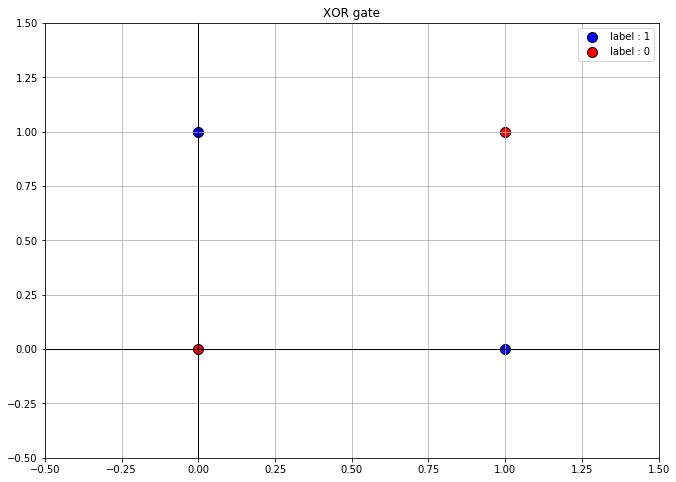

In [5]:
# XOR inputs & Corresponding outputs
X_train = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]).T
Y_train = np.array([0, 1, 1, 0])
# Visualizing XOR gate
xlim = (-.5, 1.5)
ylim = (-.5, 1.5)
plot(X_train, Y_train, title='XOR gate', s=100, axis=True, xlim=xlim, ylim=ylim)

In [6]:
# 학습
d = Logistic(X_train, Y_train, X_train, Y_train, num_iterations=1000, learning_rate=0.5, print_cost=True)

Cost after iteration 0: 1.192498
Cost after iteration 100: 0.693341
Cost after iteration 200: 0.693150
Cost after iteration 300: 0.693147
Cost after iteration 400: 0.693147
Cost after iteration 500: 0.693147
Cost after iteration 600: 0.693147
Cost after iteration 700: 0.693147
Cost after iteration 800: 0.693147
Cost after iteration 900: 0.693147
train accuracy: 25.0 %
test accuracy: 25.0 %


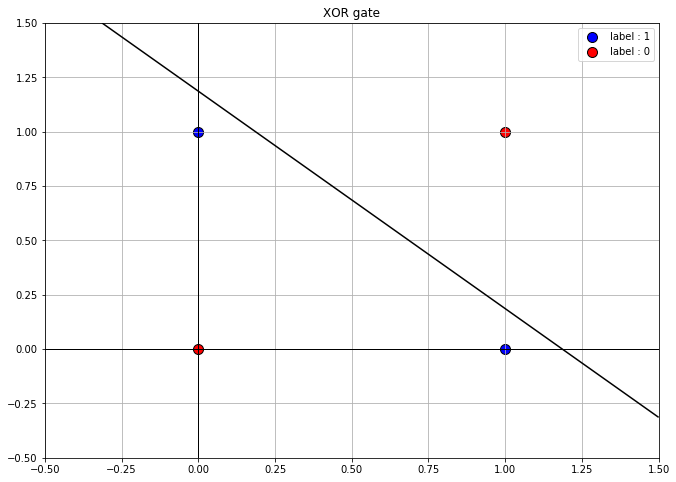

In [7]:
w = d['w']
b = d['b']
draw_boundary(w, b, X_train, Y_train, title='XOR gate', colormap=False, s=100, axis=True, xlim=xlim, ylim=ylim)

앞 시간에 구현한 Least Square classifier, Logistic Regression은 모두 선형분류기(Linear classifier)이므로 위와 같이 Non-linear한 데이터에 대해서는 학습이 어려움

## 4 - 신경망 모델(Neural Network model)

로지스틱 회귀(Logistic Regression)은 기본적으로 선형 판별자(Linear Classifier)이기 때문에 비선형 데이터(Non-linear dataset)에 대해서는 잘 동작하지 않는다. 이를 해결하기 위해 hidden layer 1층을 추가한 신경망(Nueral Network)을 구현할 것이다. 

**Here is our model**:
<img src="figures/classification_kiank.png" style="width:600px;height:400px;">

**Mathematically**:

각각의 데이터 $x^{(i)}$에 대해:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = ReLU(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

데이터셋에 대해 손실함수(Loss function):
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: 신경망을 구현하기 위한 Steps:
    1. 신경망 구조를 정의 (e.g., number of input units,  number of hidden units, etc). 
    2. 모델 파라미터 초기화
    3. Loop:
        - forward 전파
        - 손실 값 계산
        - 그레디언트 계산을 위한 backward 전파
        - 파라미터 업데이트(Gradient descent algorithm)


**시그모이드의 한계점**

<img src="figures/sigmoid.png" style="width:300px;height:300px;">


위 그래프에서 알 수 있듯이, x의 값이 양 끝으로 향하면 그 지역의 기울기는 매우 작아서 거의 0에 가까워진다. 즉, y의 값들이 x의 반응에 덜 반응하는 경향이 있는데, 이는 'Gradient Vanishing'이라는 문제를 야기시킨다. Backward 연산동안, 이러한 0에 가까운 기울기가 계속 곱해짐에 따라 그레디언트가 거의 0에 수렴하여 네트워크는 더이상 학습이 어려워지거나 급격하게 천천히 학습한다.

### Why ReLU?



<img src="figures/relu.png" style="width:300px;height:300px;">

ReLU는 그래프에서 보이는 것처럼 0보다 작을 때 계속 0의 값을 가지다가, 0의 값 이상일 때 선형 관계를 가지는 형태이다. 이는 0보다 큰 값에 대해서는 그래디언트가 계속 1의 값을 가지기 때문에 앞서 언급한 'Gradient Vanishing'문제는 어느정도 해결할 수 있다.

하지만 음수의 활성은 업데이트 하지 못하는 문제가 있고, 목적함수가 볼록함수(Convex)가 아니므로 'Local optimal' 지점이 존재하여 이는 학습을 더 어렵게 만들 수 있다.

In [8]:
# ReLU 함수정의
def ReLU(z):
    return np.maximum(0, z)

### 4.1 - 신경망의 구조 정의 ####

**실습:** 다음 세개의 변수를 지정하시오:
    - n_x: 입력단(input layer)의 크기(number of units)
    - n_h: hidden layer의 크기(number of units) --> (4로 세팅) 
    - n_y: 출력단(output layer)의 크기(number of units)

**힌트:** n_x와 n_y는 X와 Y의 shape을 이용해서 구하고 n_h는 직접 손으로 작성

In [9]:
# GRADED FUNCTION: layer_sizes

def layer_sizes(X, Y):
    """   
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

In [10]:
from OL_utils import layer_sizes_test_case
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


### 4.2 - 모델 파라미터 초기화(Initialization) ####

**실습:** `initialize_parameters()`함수 구현

**Instructions**:
- 파라미터 shape 체크하기
- 파라미터의 각 요소는 랜덤 값으로 initialization
    - Use: `np.random.randn(a,b) * 0.01` ,(a,b)는 각 파라미터 shape.
- bias는 0으로 initialization
    - Use: `np.zeros((a,b))`

In [13]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y, init_scale=False):
    """
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2019)
    
    ### START CODE HERE ### (≈ 4 lines of code)
    if init_scale:
        W1 = np.random.randn(n_h, n_x) * 0.01
        b1 = np.random.randn(n_h, 1) * 0.01
        W2 = np.random.randn(n_y, n_h) * 0.01
        b2 = np.random.randn(n_y, 1) * 0.01
    else:
        W1 = np.random.randn(n_h, n_x)
        b1 = np.random.randn(n_h, 1)
        W2 = np.random.randn(1, n_h)
        b2 = np.random.randn(1, 1)
    ### END CODE HERE ###
    
    # 파라미터 shape 체크
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [14]:
from OL_utils import initialize_parameters_test_case
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.21767896  0.82145535]
 [ 1.48127781  1.33186404]
 [-0.36186537  0.68560883]
 [ 0.57376143  0.28772767]]
b1 = [[-0.23563426]
 [ 0.95349024]
 [-1.6896253 ]
 [-0.34494271]]
W2 = [[ 0.0169049  -0.51498352  0.24450929 -0.18931261]]
b2 = [[2.67217242]]


### 4.3 - The Loop ####

**실습:** `forward()`함수를 구현하시오

**Instructions**:
- 위의 mathematical 수식 부분 참조
- `sigmoid()` 함수는 OL_utils.py에서 일괄적으로 임포트
- `ReLU()`함수 사용
- 단계적으로 구현해야 할 것:
    1. 로지스틱 구현할때와 마찬가지로 `parameters[".."]`딕셔너리로부터 파라미터를 추출 (`initialize_parameters()`함수의 출력)
    2. forward를 구현하고 $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}(=\hat{Y})$를 계산 (학습데이터셋에 대한 예측(prediction)의 벡터를 나타낸다).
- backward 전파 연산에 필요한 값들은 "`cache`"에 저장. 이 `cache`는 backward()함수의 인풋으로 들어갈 것

In [15]:
# GRADED FUNCTION: forward_propagation

def forward(X, parameters):
    """
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    ### END CODE HERE ###
    
    # Implement Forward Propagation to calculate A2(=Yhat) (probabilities)
    ### START CODE HERE ### (≈ 4 lines of code)
    Z1 = np.dot(W1, X) + b1
    A1 = ReLU(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    ### END CODE HERE ###
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [16]:
from OL_utils import forward_propagation_test_case

X_assess, parameters = forward_propagation_test_case()

A2, cache = forward(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']), np.mean(cache['A1']), np.mean(cache['Z2']), np.mean(cache['A2']))

-0.0004997557777419913 0.009407450992324358 0.000320787397351217 0.5000801968460385



위에서 계산한 $A^{[2]}(=\hat{Y})$ (in the Python variable "`A2`")는 모든 데이터에 대한 확률예측값인 $a^{[2](i)}(=\hat{y}^{(i)})$의 벡터이다. 손실함수는 다음과 같이 계산한다.

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(\hat{y}^{(i)}\right) + (1-y^{(i)})\log\left(1- \hat{y}^{(i)}\right) \large{)} \small\tag{13}$$

**실습:**

$J$ 계산을 위한`compute_cost()`함수를 구현하시오

**Instructions:**

$- \sum\limits_{i=1}^{m}  y^{(i)}\log(\hat{y}^{(i)})$ 식을 구현하기 위한 코드는 아래와 같다.
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # 루프없이 행렬연산으로만 구현가능하다
```

(바로 `np.dot()`함수를 써도 됨)

In [17]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    """
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] # number of example
    
    # Retrieve W1 and W2 from parameters
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 = parameters['W1']
    W2 = parameters['W2']
    ### END CODE HERE ###
    
    # Compute the cross-entropy cost
    ### START CODE HERE ### (≈ 2 lines of code)
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)     # 파이썬 숫자로 출력하기 위함
                                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [18]:
from OL_utils import compute_cost_test_case

A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.6929198937761266


forward동안 계산된 cache를 이용하여 backward propagation 연산을 구현할 수 있다.

**실습 :** `backward()` 함수를 구현하시오.

**Instructions**:

실제로 backpropagation연산 구현은 딥러닝에서 굉장히 어려운 일에 속한다. 하단 오른편 6개의 식을 참고하여 구현한다. (왼편 식의 vectorized version)

<img src="figures/grad_summary.png" style="width:600px;height:300px;">

$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (\hat{y}^{(i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * \mathbb 1(z_1^{(i)} \geq 0) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- $*$ 는 요소별 곱을 의미
- 각 그래디언트를 나타내는 notation들은 다음과 같다
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$


In [19]:
# GRADED FUNCTION: backward_propagation

def backward(parameters, cache, X, Y):
    """
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 = parameters['W1']
    W2 = parameters['W2']
    ### END CODE HERE ###
        
    # Retrieve also A1, Z1 and A2 from dictionary "cache".
    ### START CODE HERE ### (≈ 2 lines of code)
    A1 = cache['A1']
    Z1 = cache['Z1']
    A2 = cache['A2']
    ### END CODE HERE ###
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### (≈ 8 lines of code, corresponding to 6 equations on slide above)
    dZ2= (A2 - Y) / m
    dW2 = np.dot(dZ2, A1.T)
    db2 = np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T, dZ2)
    dA1[Z1 < 0] = 0
    dZ1 = dA1
    dW1 = np.dot(dZ1, X.T)
    db1 = np.sum(dZ1, axis=1, keepdims=True)
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [20]:
from OL_utils import backward_propagation_test_case

parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00305808 -0.00237791]
 [ 0.00233756 -0.00330678]
 [-0.00159401  0.00123948]
 [-0.0161779   0.00701688]]
db1 = [[-0.00508616]
 [-0.00382106]
 [ 0.00265114]
 [-0.00812496]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]


**실습 :** 경사하강 알고리즘(SGD)을 이용하여 업데이트 함수를 정의하시오. (위에서 계산한(dW1, db1, dW2, db2)를 이용하여 파라미터 (W1, b1, W2, b2)를 업데이트)

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$  ($\alpha$는 learning rate,  $\theta$는 각 파라미터를 의미한다.

**Note**: 초기 learning rate값을 어떻게 잡느냐에 따라 학습 후 성능에 큰 영향을 미칠 수 있다.

<img src="figures/sgd.gif" style="width:400;height:400;"> <img src="figures/sgd_bad.gif" style="width:400;height:400;">

In [21]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate=0.01):
    """    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [22]:
from OL_utils import update_parameters_test_case

parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads, learning_rate=1.2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


### 4.4 - 4.1, 4.2, 4.3에서 구현한 코드 NN_2L()함수로 합치기 ####

위에서 neural network를 학습하기 위한 함수들을 하나의`NN_2L()`함수로 구현
- X, Y, n_h, num_iterations 등을 인수로 받고 파라미터 딕셔너리를 리턴
- Loop statement를 이용해 num_iterations만큼 파라미터 업데이트

In [23]:
def NN_2L(X, Y, n_h, num_iterations=10000, init_scale=False, learning_rate=0.01, print_cost=False):
    """
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    parameters = initialize_parameters(n_x, n_h, n_y, init_scale)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    # Loop (gradient descent)
    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))

    return parameters

In [26]:
from OL_utils import nn_model_test_case

X_assess, Y_assess = nn_model_test_case()

parameters = NN_2L(X_assess, Y_assess, 4, num_iterations=1000, init_scale=True, learning_rate=1.2, print_cost=False)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-1.38993506e+157  1.96624078e+157]
 [-2.84714465e+157  4.02764997e+157]
 [-3.61865372e-003  6.85608831e-003]
 [ 4.21463520e-003  3.88328732e-003]]
b1 = [[ 2.27204004e+157]
 [ 4.65404953e+157]
 [-1.68962530e-002]
 [-4.38702267e-003]]
W2 = [[-3.31061750e+157 -6.78147285e+157  2.44509292e-003 -5.14703469e-004]]
b2 = [[0.62485519]]


/home/yjjerico/Jupyter/SK_Hynix/OL_utils.py:65: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/isl_server2/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


### 4.5 데이터 클래스 예측(prediction)

**실습 :** 클래스를 예측하는 predict()함수를 구현하시오.

 - forward함수에서 출력된 값을 이용한다.

**Reminder**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
$\hat{Y}$값을 thredhold값에 따라 prediction에 1또는 0을 넣어주고 싶다면

```X_new = (X > threshold)```

를 이용하라

In [27]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward(X, parameters)
    predictions = np.round(A2)
    ### END CODE HERE ###
    
    return predictions

In [28]:
from OL_utils import predict_test_case

parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


**Expected Output**: 


<table style="width:40%">
  <tr>
    <td>predictions mean :</td>
    <td> 0.666666666667 </td> 
  </tr>
  
</table>

In [29]:
# Accuracy 계산
def get_accuracy(parameters, X, Y):
    m = X.shape[1]
    predictions = predict(parameters, X)
    return (predictions == Y).sum() / m

## Non-Linear Synthetic Data 학습

 - XOR function
 - Circle Dataset
 - Moon shaped Dataset

In [30]:
# XOR inputs & Corresponding outputs
X_train = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]).T
Y_train = np.array([[0, 1, 1, 0]])

In [31]:
parameters = NN_2L(X_train, Y_train, n_h=2, num_iterations=10000, learning_rate=0.1, print_cost=True)
print('Train acc : {:.2%}'.format(get_accuracy(parameters, X_train, Y_train)))

Cost after iteration 0: 0.718675
Cost after iteration 1000: 0.474710
Cost after iteration 2000: 0.048546
Cost after iteration 3000: 0.015586
Cost after iteration 4000: 0.008793
Cost after iteration 5000: 0.006024
Cost after iteration 6000: 0.004544
Cost after iteration 7000: 0.003631
Cost after iteration 8000: 0.003014
Cost after iteration 9000: 0.002572
Train acc : 100.00%


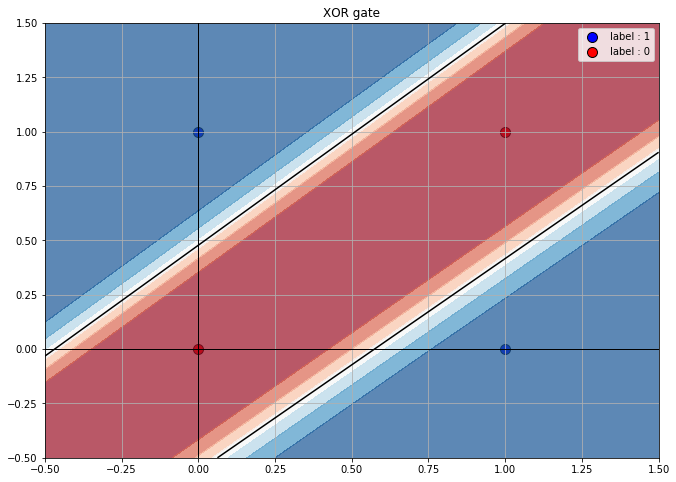

In [32]:
from OL_utils import draw_boundary

draw_boundary(parameters, X_train, Y_train, title='XOR gate', s=100, axis=True, xlim=xlim, ylim=ylim, colormap=True)

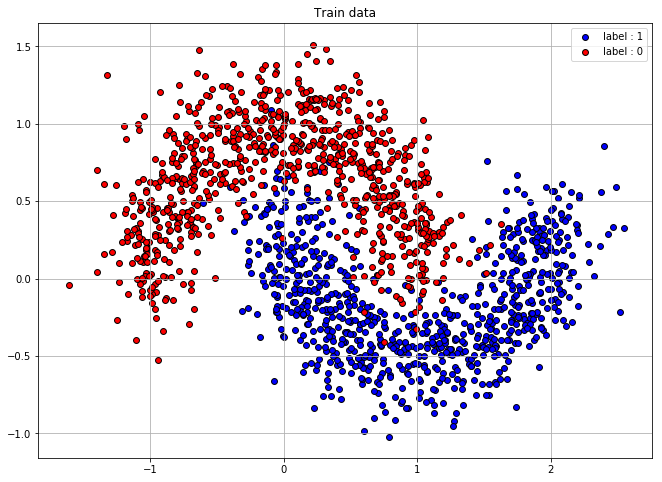

In [50]:
# Other non-linear dataset생성
from OL_utils import generate_data

(X_train, Y_train), (X_test, Y_test) = generate_data(2000, 'Moon')
plot(X_train, Y_train)

Cost after iteration 0: 0.529231
Cost after iteration 1000: 0.159601
Cost after iteration 2000: 0.115871
Cost after iteration 3000: 0.102325
Cost after iteration 4000: 0.096946
Cost after iteration 5000: 0.094402
Cost after iteration 6000: 0.092188
Cost after iteration 7000: 0.089973
Cost after iteration 8000: 0.088816
Cost after iteration 9000: 0.087912
Cost after iteration 10000: 0.087433
Cost after iteration 11000: 0.087162
Cost after iteration 12000: 0.086974
Cost after iteration 13000: 0.086624
Cost after iteration 14000: 0.086340
Cost after iteration 15000: 0.086101
Cost after iteration 16000: 0.085914
Cost after iteration 17000: 0.085756
Cost after iteration 18000: 0.085622
Cost after iteration 19000: 0.085517
Train acc : 96.75%
Test acc : 89.50%


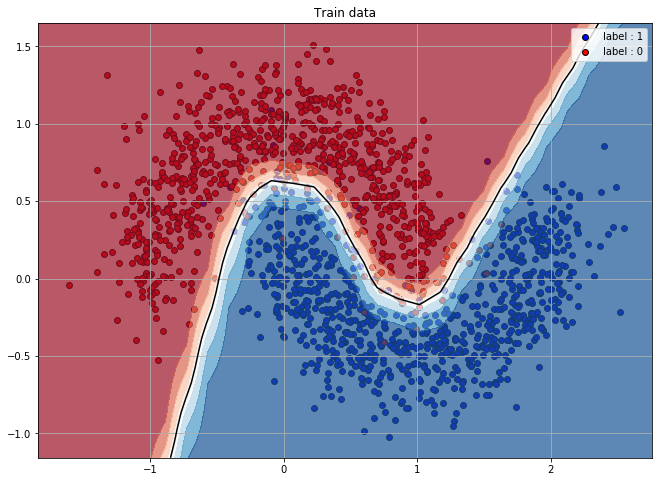

In [51]:
parameters = NN_2L(X_train, Y_train.reshape(1, -1), n_h=10, num_iterations=20000, learning_rate=0.1, print_cost=True)
print('Train acc : {:.2%}'.format(get_accuracy(parameters, X_train, Y_train)))
print('Test acc : {:.2%}'.format(get_accuracy(parameters, X_test, Y_test)))
draw_boundary(parameters, X_train, Y_train, colormap=True)

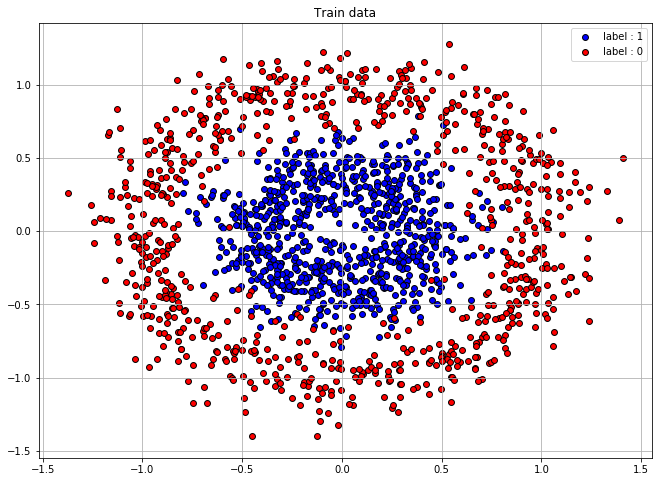

In [282]:
(X_train, Y_train), (X_test, Y_test) = generate_data(2000, 'Circle')
plot(X_train, Y_train)

Cost after iteration 0: 1.272670
Cost after iteration 1000: 0.121537
Cost after iteration 2000: 0.094065
Cost after iteration 3000: 0.084671
Cost after iteration 4000: 0.080906
Cost after iteration 5000: 0.079155
Cost after iteration 6000: 0.078219
Cost after iteration 7000: 0.077556
Cost after iteration 8000: 0.077151
Cost after iteration 9000: 0.076888
Train acc : 97.19%
Test acc : 86.25%


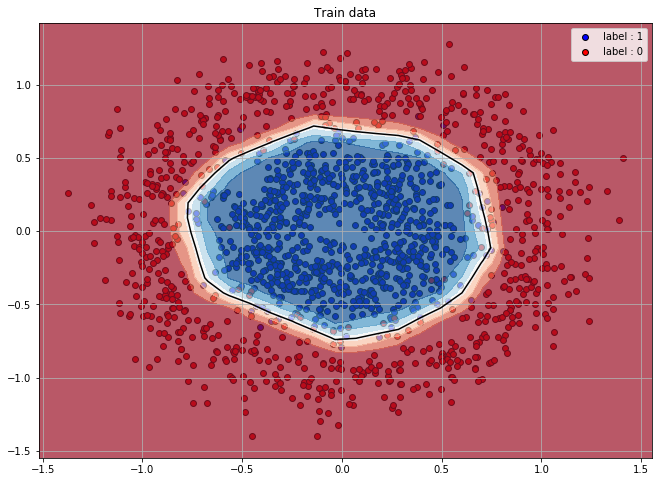

In [283]:
parameters = NN_2L(X_train, Y_train.reshape(1, -1), n_h=10, num_iterations=10000, learning_rate=0.1, print_cost=True)
print('Train acc : {:.2%}'.format(get_accuracy(parameters, X_train, Y_train)))
print('Test acc : {:.2%}'.format(get_accuracy(parameters, X_test, Y_test)))
draw_boundary(parameters, X_train, Y_train, colormap=True)

In [47]:
# (cat/non-cat) 데이터셋 로드
from RL_utils import load_dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
X_train = X_train_flatten / 255.
X_test = X_test_flatten / 255.
Y_train = Y_train_orig.reshape(1, -1)
Y_test = Y_test_orig.reshape(1, -1)

In [48]:
parameters = NN_2L(X_train, Y_train, n_h=7, num_iterations=10000, init_scale=True, learning_rate=0.0075, print_cost=True)

Cost after iteration 0: 0.691478
Cost after iteration 1000: 0.319468
Cost after iteration 2000: 0.051610
Cost after iteration 3000: 0.019406
Cost after iteration 4000: 0.010624
Cost after iteration 5000: 0.006973
Cost after iteration 6000: 0.005064
Cost after iteration 7000: 0.003919
Cost after iteration 8000: 0.003167
Cost after iteration 9000: 0.002640


In [49]:
print('Train acc : {:.2%}'.format(get_accuracy(parameters, X_train, Y_train)))
print('Test acc : {:.2%}'.format(get_accuracy(parameters, X_test, Y_test)))

Train acc : 100.00%
Test acc : 72.00%


## Non-convexity of Loss function w/ ReLU

- 각 층의 유닛이 하나씩인 경우 (w1, w2)를 생각해보자

In [270]:
from mpl_toolkits.mplot3d import Axes3D

# (w1, w2)
X = np.arange(-5, 5, 0.05)
Y = np.arange(-5, 5, 0.05)
X, Y = np.meshgrid(X, Y)

# 데이터는 Circle데이터의 첫 dimesion부분
(X_train, Y_train), (X_test, Y_test) = generate_data(2000, 'Circle')
m = X_train.shape[1]
X_train = X_train[1].reshape(-1, 1)
Y_train = Y_train.reshape(-1, 1)
weight = np.c_[X.ravel(), Y.ravel()]

In [271]:
# forward
a1 = ReLU(X_train*weight[:, 0])
a2 = sigmoid(a1*weight[:, 1])

In [269]:
# Compute Loss
logprobs = np.multiply(np.log(a2), Y_train) + np.multiply((1 - Y_train), np.log(1 - a2))
cost = -logprobs.sum(axis=0) / m
Z = cost.reshape(X.shape)

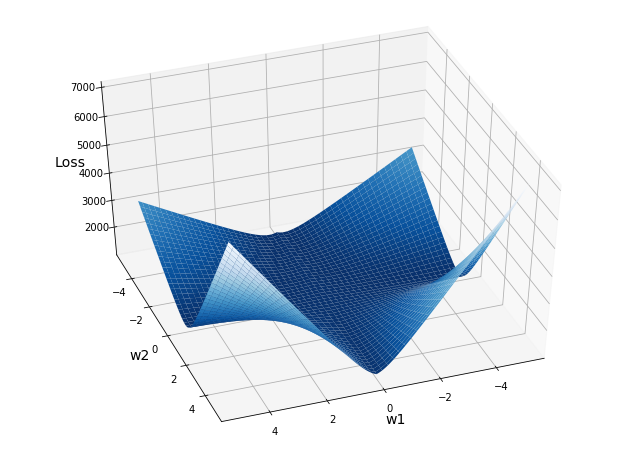

In [281]:
# plot loss surface
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.Blues_r)
ax.view_init(45, 70)
ax.set_xlabel('w1', fontsize=14)
ax.set_ylabel('w2', fontsize=14)
ax.set_zlabel('Loss', fontsize=14)
plt.show()